In [1]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy


from moscot.problems.time._lineage import TemporalProblem

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path="/home/mgander/moscot-framework_reproducibility/data/mouse_temporal"
ts=['E3.5', 'E4.5', 'E5.25', 'E5.5', 'E6.25', 'E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5a', 'E8.5b', 'E9.5', 'E10.5', 'E11.5', 'E12.5', 'E13.5']

# Moscot maps to growth rates

In [3]:
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 90000, 200000, 1100000, 2600000, 6000000, 13000000]
Cell_number_dict={}
for i in range(20):
    Cell_number_dict[ts[i]]=cells[i]

In [4]:
# Doesn't matter which adata you use to create a tp instance, the result is always the same. I just need one
# to instantiate a tp-problem
adata=sc.read(f"{Path}/anndatas/Comb_anndatas/adata_E3.5_E4.5.h5ad")
tp=TemporalProblem(adata)

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


In [66]:
cor=[]
ns=[]
d=[]
ctd=[]
for i in range(13):
    ts0=ts[i]
    ts1=ts[i+1]
    print(f'{ts0} --> {ts1}')
    print('------------------------')

    tp=tp.load(f'{Path}/moscot_maps/{ts0}_{ts1}_no_gr_TemporalProblem.pkl')
    adata=tp.adata
    time_tuple=list(tp.solutions.keys())[0]
    gr=tp[time_tuple].solution.a
    gr=gr/gr.mean()*Cell_number_dict[ts1]/Cell_number_dict[ts0]

    cell_dying=np.sum((1-gr[gr<1]))
    apoptosis_rate=float(cell_dying/len(gr))
    apoptosis_rate

    tp=TemporalProblem(adata)
    tp.score_genes_for_marginals(gene_set_proliferation='mouse',  gene_set_apoptosis='mouse')
    tp = tp.prepare('day', joint_attr=f'X_pcaS')

    A0=adata[adata.obs['day']==time_tuple[0]].copy()
    #A0.obs['gr']=z_transf(gr)
    #A0.obs['gr_init']=z_transf(list(tp.prior_growth_rates['prior_growth_rates'])[:len(A0)])

    #A0.obs['gr_t']=np.load(f'{Path}/TOME_transport_maps/{ts0}_growth_rates.npy')
    A0.obs['gr']=gr
    A0.obs['gr_init']=list(tp.prior_growth_rates['prior_growth_rates'])[:len(A0)]


    cts=list(set(A0.obs['cell_type']))

    for ct in cts:
        As=A0[A0.obs['cell_type']==ct]
        #sns.scatterplot(data=As.obs, x='gr', y='gr_init', s=5)
        #plt.xlim(0,4)
        #plt.pause(0.01)
        #if len(As)>400:
        ns.append(len(As))
        cor.append(scipy.stats.pearsonr(x=As.obs['gr'], y=As.obs['gr_init'])[0])
        d.append(ts0)
        ctd.append(ct)
    #sns.histplot(cor, bins=np.linspace(-1,1,51))
    #plt.pause(0.001)
    #sns.scatterplot(x=ns, y=cor)
    #plt.pause(0.001)

E3.5 --> E4.5
------------------------
E4.5 --> E5.25
------------------------
E5.25 --> E5.5
------------------------
E5.5 --> E6.25
------------------------
E6.25 --> E6.5
------------------------
E6.5 --> E6.75
------------------------
E6.75 --> E7.0
------------------------
E7.0 --> E7.25
------------------------
E7.25 --> E7.5
------------------------
E7.5 --> E7.75
------------------------
E7.75 --> E8.0
------------------------
E8.0 --> E8.25
------------------------
E8.25 --> E8.5a
------------------------


In [67]:
df=pd.DataFrame({'n':ns, 'cor':cor, 'd':d, 'ct':ctd})

<Axes: xlabel='n', ylabel='cor'>

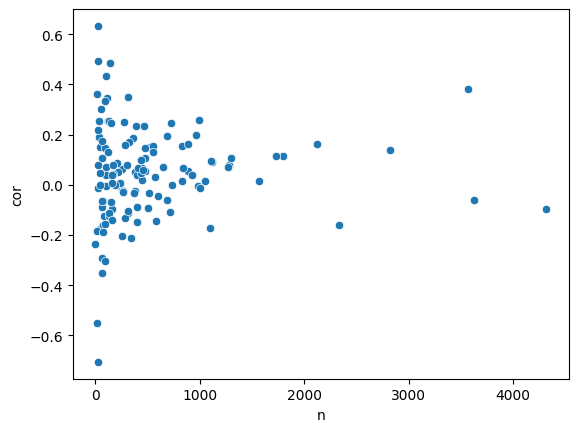

In [68]:
sns.scatterplot(data=df, x='n', y='cor')

In [69]:
df.sort_values('cor')

,n,cor,d,ct
122,25,-0.705983,E8.25,Definitive endoderm
14,20,-0.549621,E6.25,Embryonic visceral endoderm
37,62,-0.352062,E7.25,Notochord
98,95,-0.302133,E8.0,First heart field
56,69,-0.290714,E7.5,Notochord
...,...,...,...,...
33,3567,0.382471,E7.25,Epiblast
88,102,0.434832,E8.0,Somatic mesoderm
13,143,0.486039,E6.25,Epiblast
106,24,0.492642,E8.25,Primordial germ cells


In [70]:
k=101

corn=[]
for n in np.linspace(0,5000,k):
    dfn=df[df['n']>n]
    corn.append(dfn['cor'].mean())

<Axes: >

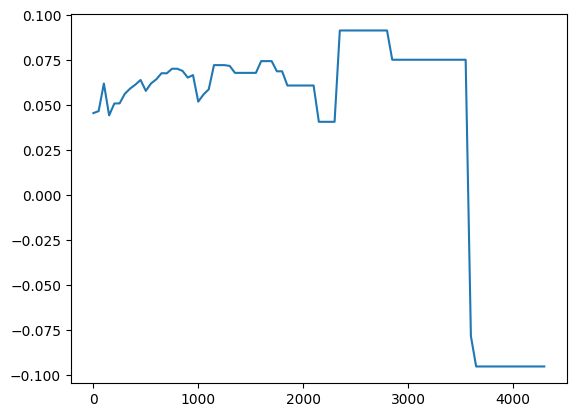

In [71]:
sns.lineplot(x=np.linspace(0,5000,k), y=corn)

In [83]:
dfn=df[df['n']>200]

In [84]:
dfn['cor'].mean()

0.050977227172610794

In [39]:
ns

[]

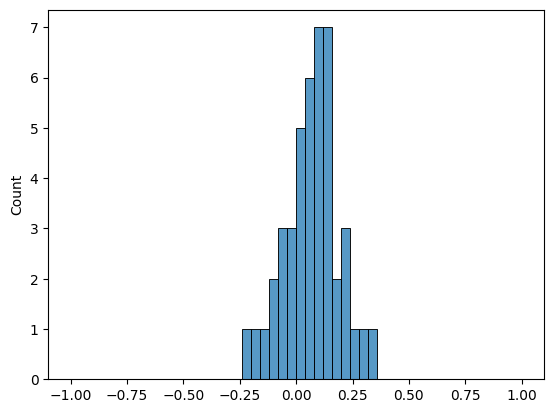

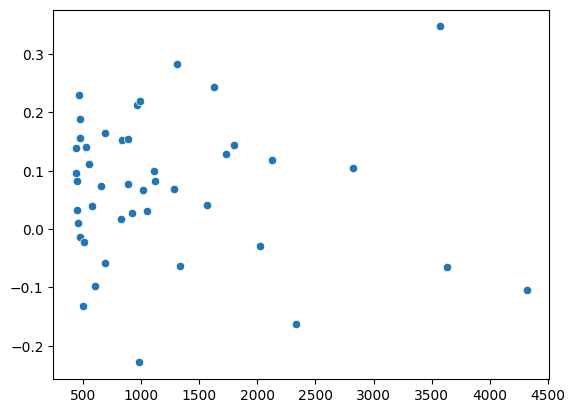

In [35]:
sns.histplot(cor, bins=np.linspace(-1,1,51))
plt.pause(0.001)
sns.scatterplot(x=ns, y=cor)
plt.pause(0.001)

In [31]:
np.mean(cor)

0.05322615634428257

In [303]:
As=A0[A0.obs['cell_type']=='Blood progenitors']

(0.0, 4.0)

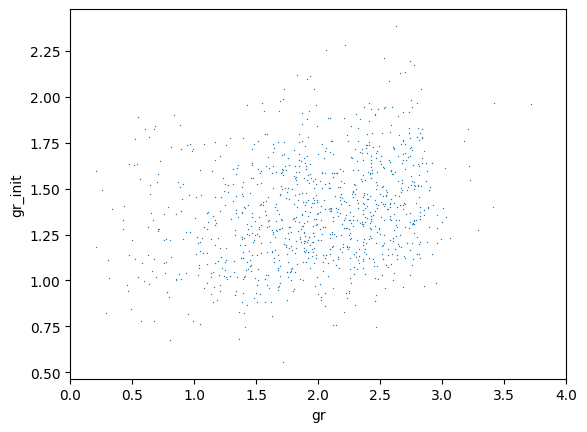

In [305]:
sns.scatterplot(data=As.obs, x='gr', y='gr_init', s=1)
plt.xlim(0,4)

In [243]:
adata

AnnData object with n_obs × n_vars = 24502 × 29452
    obs: 'cellID', 'day', 'cell_state', 'cell_type', 'group', 'sample', 'origin', 'proliferation', 'apoptosis'
    var: 'features', 'gene_names'
    obsm: 'X_pcaS', 'X_umap3'

In [260]:
scanpy.pp.scale(A0)

In [261]:
cc_genes_mouse=list(pd.read_csv(f'{Path}/utils/mouse_proliferation.txt', header=None)[0])
scanpy.tl.score_genes(A0, cc_genes_mouse)

(0.0, 4.0)

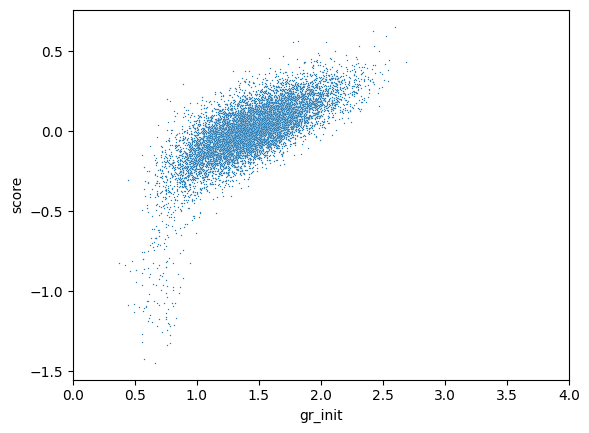

In [262]:
sns.scatterplot(data=A0.obs, x='gr_init', y='score', s=1)
plt.xlim(0,4)

(0.0, 4.0)

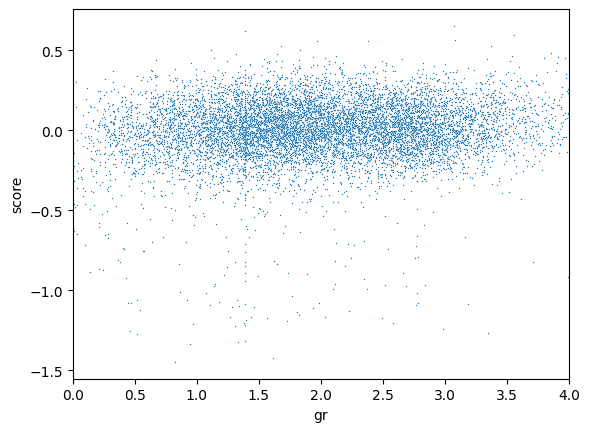

In [263]:
sns.scatterplot(data=A0.obs, x='gr', y='score', s=1)
plt.xlim(0,4)

In [264]:
scipy.stats.pearsonr(x=A0.obs['gr'], y=A0.obs['score'])

(0.11088526113803816, 8.131657700462687e-29)

In [15]:
sns.scatterplot(data=A0.obs, x='gr_t', y='gr_init', s=1)
plt.xlim(0,4)

ValueError: Could not interpret value `gr_t` for parameter `x`

In [16]:
scipy.stats.pearsonr(x=A0.obs['gr'], y=A0.obs['gr_init'])

(-0.12398674912951577, 0.24430309651214144)

In [17]:
scipy.stats.pearsonr(x=A0.obs['gr_t'], y=A0.obs['gr_init'])

KeyError: 'gr_t'

<Axes: xlabel='gr', ylabel='Count'>

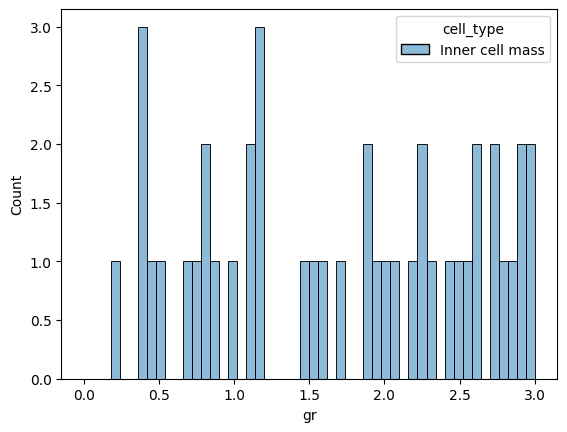

In [24]:
# Only k biggest cell types
cts=list(A0.obs.value_counts('cell_type').index)[:5]
A0s=A0[A0.obs['cell_type'].isin(cts)].copy()
sns.histplot(data=A0s.obs, x='gr', hue='cell_type', bins=np.linspace(0,3,51))

<Axes: xlabel='gr', ylabel='Count'>

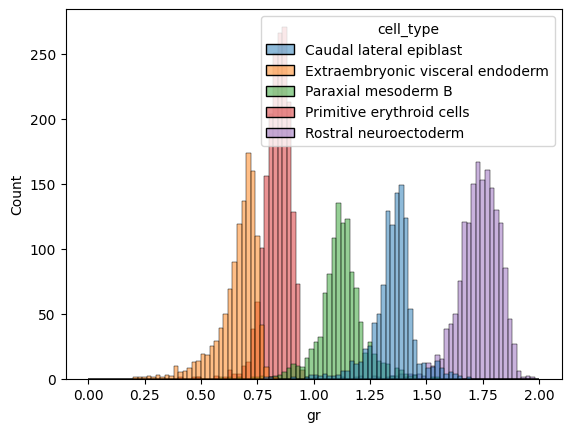

In [191]:
# Only k biggest cell types
cts=list(A0.obs.value_counts('cell_type').index)[:5]
A0s=A0[A0.obs['cell_type'].isin(cts)].copy()
sns.histplot(data=A0s.obs, x='gr', hue='cell_type', bins=np.linspace(0,2,101))

In [157]:
dfs=A0.obs.groupby('cell_type').mean(['gr_init'])

<Axes: xlabel='gr', ylabel='gr_init'>

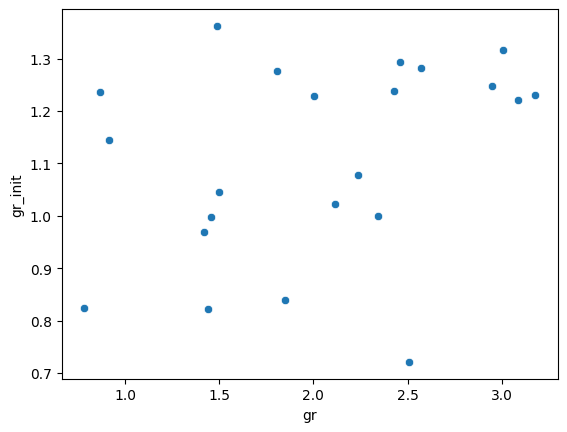

In [158]:
sns.scatterplot(data=dfs, x='gr', y='gr_init')

In [159]:
scipy.stats.pearsonr(x=dfs['gr'], y=dfs['gr_init'])

(0.3375249405456633, 0.12448718329387236)

In [160]:
scipy.stats.spearmanr(dfs['gr'], dfs['gr_init'])

SpearmanrResult(correlation=0.383399209486166, pvalue=0.07817838660087381)

In [86]:
dfs

,day,group,proliferation,apoptosis,gr,gr_init
cell_type,,,,,,
Allantois,8.0,2.656036,0.278035,0.072207,1.187451,1.320369
Amniochorionic mesoderm,8.0,2.748646,0.276424,0.074846,1.195280,1.295180
Caudal lateral epiblast,8.0,2.800180,0.341842,0.069509,1.188380,1.572410
Caudal neuroectoderm,8.0,2.812613,0.338547,0.067804,1.320316,1.579520
Definitive endoderm,8.0,2.853659,0.165480,0.078785,0.841943,1.049235
Embryonic visceral endoderm,8.0,2.587302,0.169486,0.099047,1.024192,0.901466
Endothelium,8.0,2.482143,0.292346,0.105233,1.379814,1.107805
First heart field,8.0,2.568421,0.278206,0.073398,2.250379,1.321583
Gut,8.0,2.744361,0.266309,0.079528,1.041947,1.229439


In [50]:
tp=TemporalProblem(adata)
tp.score_genes_for_marginals(gene_set_proliferation='mouse',  gene_set_apoptosis='mouse')
tp = tp.prepare('day', joint_attr=f'X_pcaS')

In [53]:
tp.prior_growth_rates

,prior_growth_rates
cell_30635,1.466585
cell_30636,1.394676
cell_30638,1.175681
cell_30639,1.475032
cell_30642,1.838632
...,...
cell_95719,NaN
cell_95721,NaN
cell_95722,NaN
cell_95723,NaN


In [43]:
# Only k biggest cell types
cts=list(A0.obs.value_counts('cell_type').index)[:5]
A0s=A0[A0.obs['cell_type'].isin(cts)].copy()
sns.histplot(data=A0s.obs, x='gr', hue='cell_type', bins=np.linspace(0,2,101))

<Axes: xlabel='gr', ylabel='Count'>

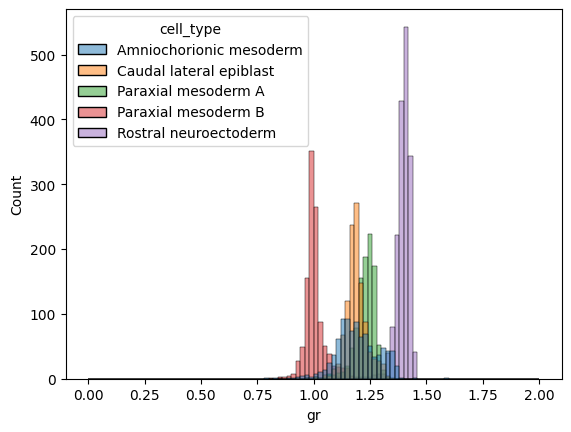

In [44]:
sns.histplot(data=A0s.obs, x='gr', hue='cell_type', bins=np.linspace(0,2,101))

In [48]:
# Only k biggest cell types
cts=list(A0.obs.value_counts('cell_type').index)[:8]
A0s=A0[A0.obs['cell_type'].isin(cts)].copy()

<Axes: xlabel='gr', ylabel='Count'>

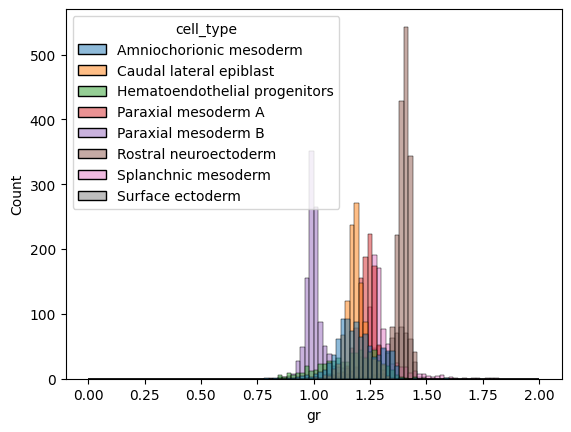

In [49]:
sns.histplot(data=A0s.obs, x='gr', hue='cell_type', bins=np.linspace(0,2,101))

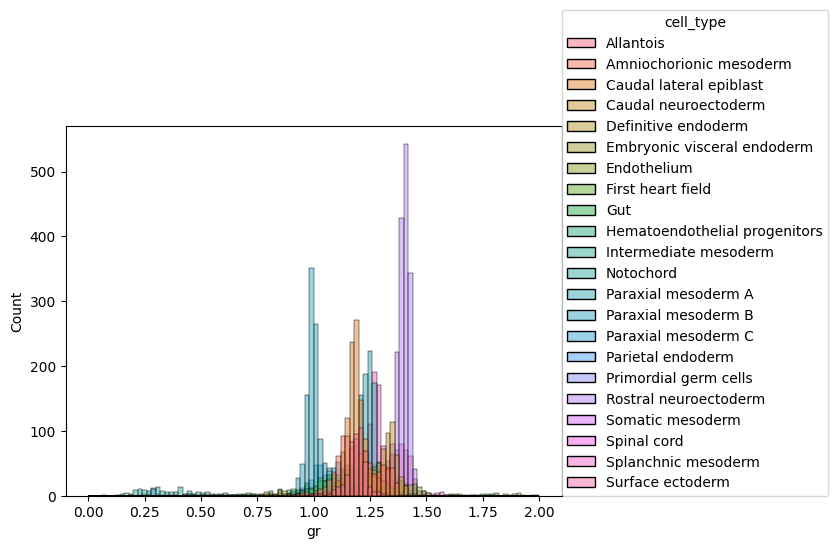

In [47]:
g=sns.histplot(data=A0.obs, x='gr', hue='cell_type', bins=np.linspace(0,2,101))
sns.move_legend(g,(1,0))

In [9]:
adata=tp.adata
adata.obs['gr_pr']=tp.prior_growth_rates
adata.obs['gr_po']=tp.posterior_growth_rates
A0=adata[adata.obs['day']==time_tuple[0]].copy()
A0.obs['gr']=gr

In [10]:
#ax=sns.histplot(data=A0.obs, x='gr', hue='cell_type', bins=np.linspace(0,5,201))
#sns.move_legend(ax,(1,0))

In [11]:
cts=list(set(A0.obs['cell_type']))

In [12]:
ns=[]
for ct in cts:
    ns.append(len(A0[A0.obs['cell_type']==ct]))

In [13]:
df=pd.DataFrame({'n':ns, 'ct':cts})
df=df.sort_values('n', ascending=False)
df.index=np.arange(len(df))

In [14]:
dfs=df.iloc[:6]

In [15]:
As=A0[A0.obs['cell_type'].isin(dfs['ct'])]

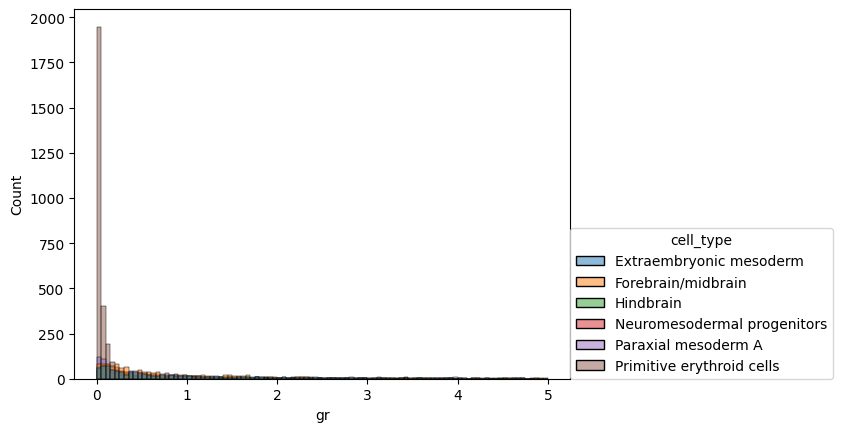

In [16]:
ax=sns.histplot(data=As.obs, x='gr', hue='cell_type', bins=np.linspace(0,5,101))
sns.move_legend(ax,(1,0))

ValueError: Axes(0.125,0.11;0.775x0.77) has no legend attached.

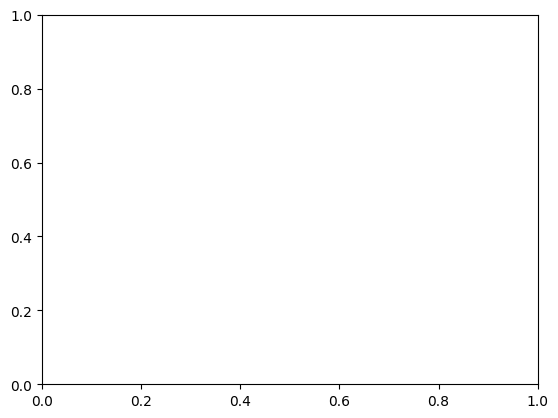

In [38]:
ax=sns.histplot(data=As.obs, x='gr_pr', hue='cell_type', bins=np.linspace(0,3,101))
sns.move_legend(ax,(1,0))

In [546]:
adata

AnnData object with n_obs × n_vars = 16824 × 29452
    obs: 'cellID', 'day', 'cell_state', 'cell_type', 'group', 'sample', 'origin', 'proliferation', 'apoptosis', 'gr_pr', 'gr_po'
    var: 'features', 'gene_names'
    obsm: 'X_pcaS', 'X_umap3'

In [337]:
adata.obs

,cellID,day,cell_state,cell_type,group,sample,origin,proliferation,apoptosis,gr_pr,gr_po
cell_30635,cell_30635,8.00,E8:Caudal neuroectoderm,Caudal neuroectoderm,2,cell_30635,Pijuan,0.260485,0.034528,1.539916,3.816089
cell_30636,cell_30636,8.00,E8:Paraxial mesoderm A,Paraxial mesoderm A,2,cell_30636,Pijuan,0.241697,0.040115,1.422081,2.891842
cell_30638,cell_30638,8.00,E8:Surface ectoderm,Surface ectoderm,2,cell_30638,Pijuan,0.181482,0.066780,1.037858,3.154767
cell_30639,cell_30639,8.00,E8:Caudal lateral epiblast,Caudal lateral epiblast,2,cell_30639,Pijuan,0.276569,0.079271,1.242563,2.264359
cell_30642,cell_30642,8.00,E8:Splanchnic mesoderm,Splanchnic mesoderm,2,cell_30642,Pijuan,0.268484,0.008921,1.744938,3.752757
...,...,...,...,...,...,...,...,...,...,...,...
cell_95722,cell_95722,8.25,E8.25:Splanchnic mesoderm,Splanchnic mesoderm,1,cell_95722,Pijuan,0.153689,0.057125,NaN,NaN
cell_95723,cell_95723,8.25,E8.25:Paraxial mesoderm A,Paraxial mesoderm A,1,cell_95723,Pijuan,0.162054,0.098392,NaN,NaN
cell_95724,cell_95724,8.25,E8.25:Extraembryonic ectoderm,Extraembryonic ectoderm,1,cell_95724,Pijuan,0.251958,0.071817,NaN,NaN
cell_95725,cell_95725,8.25,E8.25:Splanchnic mesoderm,Splanchnic mesoderm,1,cell_95725,Pijuan,0.182309,0.051910,NaN,NaN


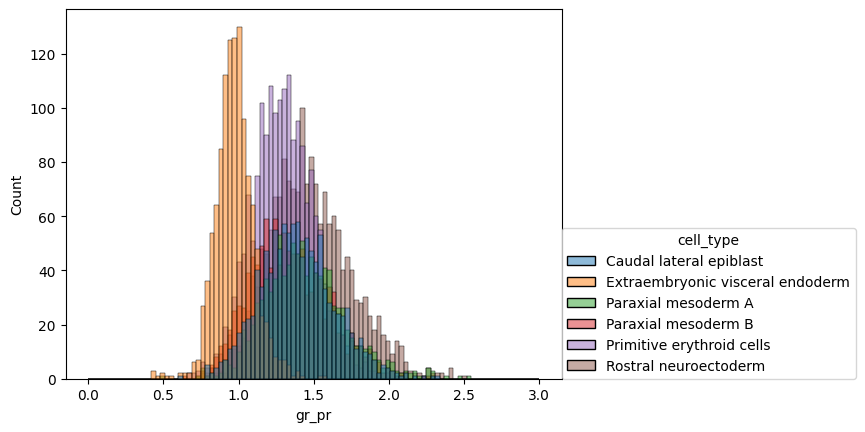

In [245]:
ax=sns.histplot(data=As.obs, x='gr_pr', hue='cell_type', bins=np.linspace(0,3,101))
sns.move_legend(ax,(1,0))

In [230]:
tp.prior_growth_rates

,prior_growth_rates
cell_30635,1.539916
cell_30636,1.422081
cell_30638,1.037858
cell_30639,1.242563
cell_30642,1.744938
...,...
cell_95722,NaN
cell_95723,NaN
cell_95724,NaN
cell_95725,NaN


In [246]:
tp.prior_growth_rates

,prior_growth_rates
cell_30635,1.539916
cell_30636,1.422081
cell_30638,1.037858
cell_30639,1.242563
cell_30642,1.744938
...,...
cell_95722,NaN
cell_95723,NaN
cell_95724,NaN
cell_95725,NaN


In [232]:
adata.obs

,cellID,day,cell_state,cell_type,group,sample,origin,proliferation,apoptosis,gr_pr,gr_po
cell_30635,cell_30635,8.00,E8:Caudal neuroectoderm,Caudal neuroectoderm,2,cell_30635,Pijuan,0.260485,0.034528,1.539916,1.898174
cell_30636,cell_30636,8.00,E8:Paraxial mesoderm A,Paraxial mesoderm A,2,cell_30636,Pijuan,0.241697,0.040115,1.422081,1.813372
cell_30638,cell_30638,8.00,E8:Surface ectoderm,Surface ectoderm,2,cell_30638,Pijuan,0.181482,0.066780,1.037858,1.246302
cell_30639,cell_30639,8.00,E8:Caudal lateral epiblast,Caudal lateral epiblast,2,cell_30639,Pijuan,0.276569,0.079271,1.242563,1.503402
cell_30642,cell_30642,8.00,E8:Splanchnic mesoderm,Splanchnic mesoderm,2,cell_30642,Pijuan,0.268484,0.008921,1.744938,2.257906
...,...,...,...,...,...,...,...,...,...,...,...
cell_95722,cell_95722,8.25,E8.25:Splanchnic mesoderm,Splanchnic mesoderm,1,cell_95722,Pijuan,0.153689,0.057125,NaN,NaN
cell_95723,cell_95723,8.25,E8.25:Paraxial mesoderm A,Paraxial mesoderm A,1,cell_95723,Pijuan,0.162054,0.098392,NaN,NaN
cell_95724,cell_95724,8.25,E8.25:Extraembryonic ectoderm,Extraembryonic ectoderm,1,cell_95724,Pijuan,0.251958,0.071817,NaN,NaN
cell_95725,cell_95725,8.25,E8.25:Splanchnic mesoderm,Splanchnic mesoderm,1,cell_95725,Pijuan,0.182309,0.051910,NaN,NaN


In [199]:
tp.prior_growth_rates

,prior_growth_rates
cell_30635,1.539916
cell_30636,1.422081
cell_30638,1.037858
cell_30639,1.242563
cell_30642,1.744938
...,...
cell_95722,NaN
cell_95723,NaN
cell_95724,NaN
cell_95725,NaN


In [ ]:
**(time_tuple[1]-time_tuple[0])

In [200]:
time_tuple[1]-time_tuple[0]

0.25

In [182]:
tp.posterior_growth_rates

,posterior_growth_rates
cell_30635,4.312301
cell_30636,3.210051
cell_30638,4.288957
cell_30639,2.216922
cell_30642,4.081030
...,...
cell_95722,NaN
cell_95723,NaN
cell_95724,NaN
cell_95725,NaN


In [ ]:
epsilon=0.005
ap_min=0.02
ap_max=0.04

for i in range(19):
    ts0=ts[i]
    ts1=ts[i+1]
    print(ts0)
    
    tp=tp.load(f'{Path}/moscot_maps/{ts0}_{epsilon}_{ap_min}_{ap_max}_TemporalProblem.pkl')
    time_tuple=list(tp.solutions.keys())[0]
    gr=tp[time_tuple].solution.a
    gr=gr/gr.mean()*Cell_number_dict[ts1]/Cell_number_dict[ts0]
    np.save(f'{Path}/moscot_maps/{ts0}_growth_rates.npy', gr)